In [1]:
import sqlite3
import pandas as pd

conn = sqlite3.connect(':memory:')
cursor = conn.cursor()
print("Database connected.")

# load csv files
age_dependency = pd.read_csv("../data/2_Age dependency ratio (% of working-age population).csv", skiprows=4)
life_expectancy = pd.read_csv("../data/2_Life expectancy at birth, total (years).csv", skiprows=4)
metadata = pd.read_csv("../data/metadata.csv", skiprows=4)

age_dependency.to_sql("age_dependency", conn, if_exists="replace", index=False)
life_expectancy.to_sql("life_expectancy", conn, if_exists="replace", index=False)
metadata.to_sql("metadata", conn, if_exists="replace", index=False)

Database connected.


261

In [2]:
query1 = """
SELECT AVG(change) AS average_expectancy_change
FROM (SELECT "Country Name", "1960", "2023", "2023"-"1960" AS change
FROM age_dependency)
"""

display(pd.read_sql(query1, conn))

,average_expectancy_change
0,-21.592151


In [3]:
query2 = """
SELECT AVG(change) AS average_expectancy_change
FROM (SELECT "Country Name", "1960", "2023", "2023"-"1960" AS change
FROM life_expectancy)
"""

display(pd.read_sql(query2, conn))

,average_expectancy_change
0,19.467608


In [4]:
query = """
CREATE TABLE life_vs_dependency_change AS
SELECT life_expectancy."Country Name", metadata.AFW AS code, metadata."Unnamed: 1" AS region, metadata."Unnamed: 2" AS income, (life_expectancy."2023"-life_expectancy."1960") AS life_expectancy_change,(age_dependency."2023"-age_dependency."1960") AS age_dependency_change
FROM life_expectancy
LEFT JOIN metadata ON life_expectancy."Country Code" = metadata.AFW
LEFT JOIN age_dependency ON life_expectancy."Country Name" = age_dependency."Country Name"
WHERE "Unnamed: 1" IS NOT NULL AND "life_expectancy_change" IS NOT NULL AND "age_dependency_change" IS NOT NULL
"""

cursor.execute(query)
conn.commit()

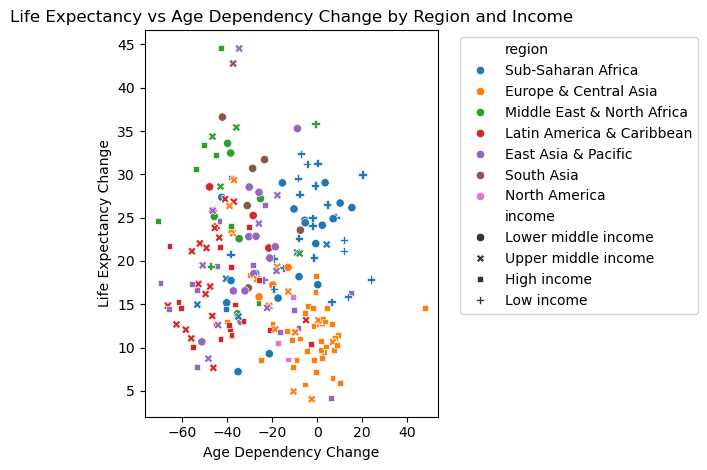

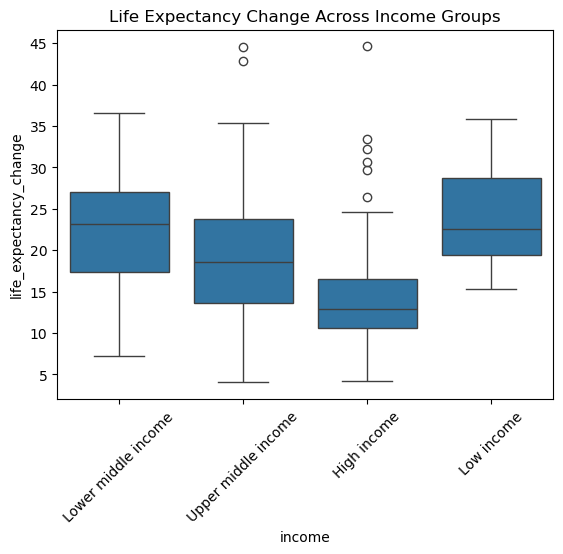

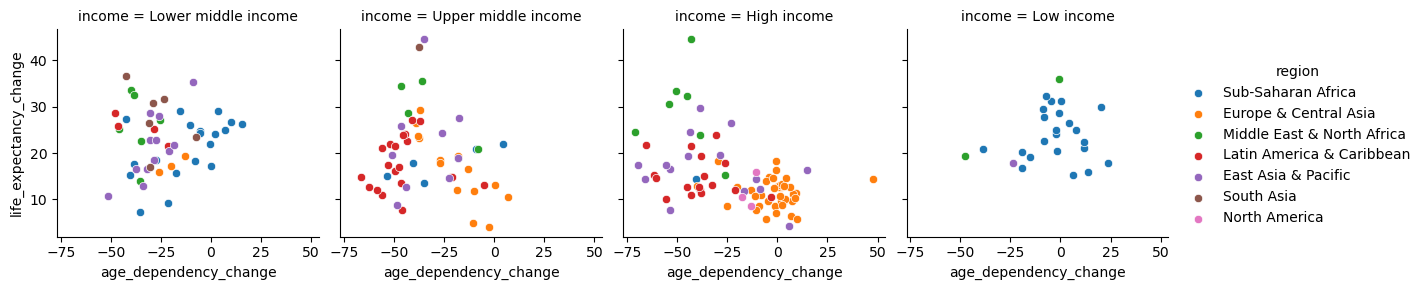

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_sql('SELECT * FROM life_vs_dependency_change', conn)

sns.scatterplot(data=df, x='age_dependency_change', y='life_expectancy_change', hue='region', style='income')
plt.title('Life Expectancy vs Age Dependency Change by Region and Income')
plt.xlabel('Age Dependency Change')
plt.ylabel('Life Expectancy Change')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../figures/2scatter.png')
plt.show()

sns.boxplot(data=df, x='income', y='life_expectancy_change')
plt.title('Life Expectancy Change Across Income Groups')
plt.xticks(rotation=45)
plt.savefig('../figures/2expectancy_across_income.png')
plt.show()

g = sns.FacetGrid(df, col='income', hue='region')
g.map(sns.scatterplot, 'age_dependency_change', 'life_expectancy_change')
plt.savefig('../figures/2faceted.png')
g.add_legend()